In [1]:
import re
import string
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk import flatten
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('df.csv')
df = df.rename(columns={'Unnamed: 0':'index'})
df = df.fillna('')

In [3]:
df.columns

Index(['index', 'adult', 'original_language', 'original_title', 'overview',
       'popularity', 'tagline', 'vote_average', 'vote_count', 'imdbId',
       'tmdbId', 'new_genres', 'new_production_companies',
       'new_production_countries', 'new_spoken_languages', 'new_keywords',
       'new_cast', 'combine_text'],
      dtype='object')

In [4]:
df = df[['index','original_title','imdbId','tmdbId','original_language','adult','popularity',
         'vote_average','vote_count','new_genres','new_production_companies','new_production_countries',
         'new_spoken_languages','new_cast','new_keywords','tagline','overview','combine_text']]

In [5]:
display(df.head(3))
df.shape

,index,original_title,imdbId,tmdbId,original_language,adult,popularity,vote_average,vote_count,new_genres,new_production_companies,new_production_countries,new_spoken_languages,new_cast,new_keywords,tagline,overview,combine_text
0,0,Toy Story,114709,862,en,False,21.946943,7.7,5415.0,"'Animation', 'Comedy', 'Family'",'Pixar Animation Studios','United States of America','English',"'Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim ...","'jealousy', 'toy', 'boy', 'friendship', 'frien...",,"Led by Woody, Andy's toys live happily in his ...","led by woody, andy's toys live happily in his ..."
1,1,Jumanji,113497,8844,en,False,17.015539,6.9,2413.0,"'Adventure', 'Fantasy', 'Family'","'TriStar Pictures', 'Teitler Film', 'Interscop...",'United States of America',"'English', 'Français'","'Robin Williams', 'Jonathan Hyde', 'Kirsten Du...","'board game', 'disappearance', ""based on child...",Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,when siblings judy and peter discover an encha...
2,2,Grumpier Old Men,113228,15602,en,False,11.712900,6.5,92.0,"'Romance', 'Comedy'","'Warner Bros.', 'Lancaster Gate'",'United States of America','English',"'Walter Matthau', 'Jack Lemmon', 'Ann-Margret'...","'fishing', 'best friend', 'duringcreditsstinge...",Still Yelling. Still Fighting. Still Ready for...,A family wedding reignites the ancient feud be...,a family wedding reignites the ancient feud be...


(46910, 18)

# EDA

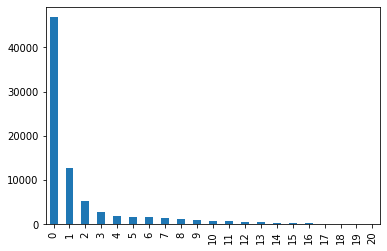

In [6]:
df['original_language'].value_counts()[0:10].plot(kind='bar');
df['adult'].value_counts()[0:10].plot(kind='bar');
round(df['popularity']).astype('int').value_counts()[0:21].plot(kind='bar');
#round(df['vote_average']).astype('int').value_counts().plot(kind='bar');

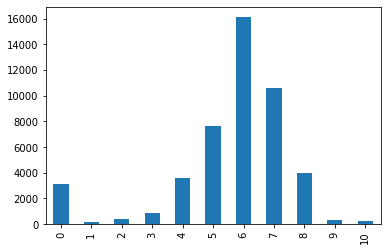

In [7]:
round(df['vote_average']).astype('int').value_counts().sort_index().plot(kind='bar')

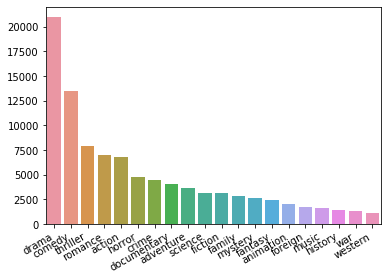

In [8]:
df['new_genres'] = df['new_genres'].apply( lambda x: re.sub('[%s]'%re.escape(string.punctuation),'',x))
df['new_genres'] = df['new_genres'].apply( lambda x: x.lower())
genres = [text for text in df['new_genres']]
genres = ' '.join(genres).split()
count_genre = Counter(genres)
top_genre = count_genre.most_common(20)
pd.DataFrame(top_genre);
genre_words = [word[0] for word in top_genre]
genre_counts = [word[1] for word in top_genre]
sns.barplot(x=genre_words, y=genre_counts)

plt.xticks(rotation=30, ha='right')

plt.show()

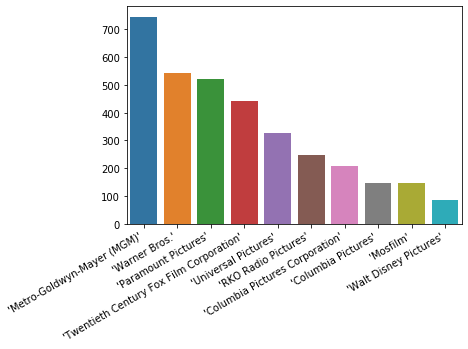

In [9]:

production_companies = [text for text in df['new_production_companies']]
#production_companies = ' '.join(production_companies).split()

count_production_companies = Counter(production_companies)
top_production_companies = count_production_companies.most_common(20)
pd.DataFrame(top_production_companies);

production_companies_words = [word[0] for word in top_production_companies]
production_companies_counts = [word[1] for word in top_production_companies]

sns.barplot(x=production_companies_words[1:11], y=production_companies_counts[1:11])

plt.xticks(rotation=30, ha='right')

plt.show()

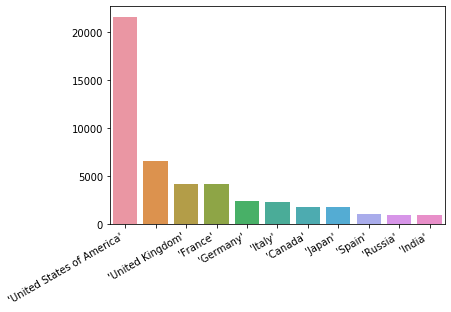

In [10]:
production_countries = [text for text in df['new_production_countries']]
countries = [] 

for i in range (0,len(production_countries)):
    x = production_countries[i].split(', ')
    countries.append(x)

countries = flatten(countries)   

count_production_countries = Counter(countries)
top_production_countries = count_production_countries.most_common(20)
pd.DataFrame(top_production_countries);

production_countries_words = [word[0] for word in top_production_countries]
production_countries_counts = [word[1] for word in top_production_countries]

sns.barplot(x=production_countries_words[0:11], y=production_countries_counts[0:11])

plt.xticks(rotation=30, ha='right')

plt.show()

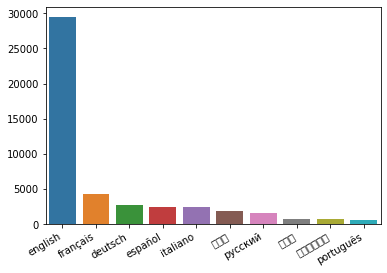

In [11]:
df['new_spoken_languages'] = df['new_spoken_languages'].apply( lambda x: re.sub('[%s]'%re.escape(string.punctuation),'',x))
df['new_spoken_languages'] = df['new_spoken_languages'].apply( lambda x: x.lower())

spoken_languages = [text for text in df['new_spoken_languages']]
spoken_languages = ' '.join(spoken_languages).split()


count_spoken_languages = Counter(spoken_languages)
top_spoken_languages = count_spoken_languages.most_common(20)
pd.DataFrame(top_spoken_languages);

spoken_languages_words = [word[0] for word in top_spoken_languages]
spoken_languages_counts = [word[1] for word in top_spoken_languages]

sns.barplot(x=spoken_languages_words[0:10], y=spoken_languages_counts[0:10])

plt.xticks(rotation=30, ha='right')

plt.show()

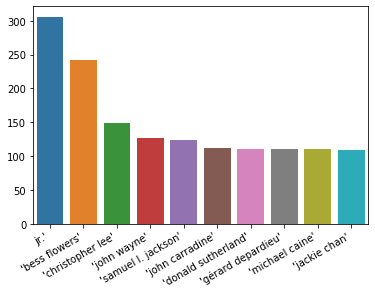

In [12]:
df['new_cast'] = df['new_cast'].apply( lambda x: x.lower())
df['new_cast'] = df['new_cast'].apply( lambda x: re.sub(('"\"'),' ',x))


cast_member = [text for text in df['new_cast']]


cast_list = [] 

for i in range (0,len(cast_member)):
    x = cast_member[i].split(', ')
    cast_list.append(x)


cast_list = flatten(cast_list)   


count_cast = Counter(cast_list)

 
top_cast = count_cast.most_common(20)
pd.DataFrame(top_cast);

cast_words = [word[0] for word in top_cast]
cast_counts = [word[1] for word in top_cast]

sns.barplot(x=cast_words[1:11], y=cast_counts[1:11])

plt.xticks(rotation=30, ha='right');


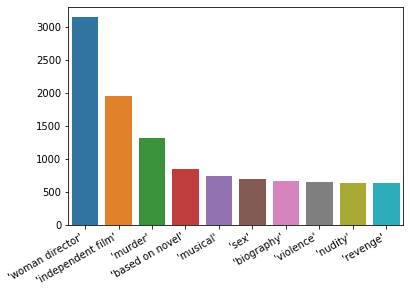

In [13]:
df['new_keywords'] = df['new_keywords'].apply( lambda x: x.lower())
keywords = [text for text in df['new_keywords']]

words = [] 

for i in range (0,len(keywords)):
    x = keywords[i].split(', ')
    words.append(x)

words = flatten(words)   
count_keywords = Counter(words)

top_keywords = count_keywords.most_common(20)
pd.DataFrame(top_keywords);

keywords_words = [word[0] for word in top_keywords]
keywords_counts = [word[1] for word in top_keywords]

sns.barplot(x=keywords_words[1:11], y=keywords_counts[1:11])

plt.xticks(rotation=30, ha='right');


How do you calculate the rank of movies and TV shows on the Top Rated Movies and Top Rated TV Show lists?
The following formula is used to calculate the Top Rated 250 titles. This formula provides a true 'Bayesian estimate', which takes into account the number of votes each title has received, minimum votes required to be on the list, and the mean vote for all titles:

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C

Where:

R = average for the movie (mean) = (rating)

v = number of votes for the movie = (votes)

m = minimum votes required to be listed in the Top Rated list (currently 25,000)

C = the mean vote across the whole report

Please be aware that the Top Rated Movies Chart only includes theatrical features: shorts, TV movies, miniseries and documentaries are not included in the Top Rated Movies Chart. The Top Rated TV Shows Chart includes TV Series, but not TV episodes or Movies.

https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#

In [14]:
m = df['vote_count'].quantile(0.95)
m

421.0

In [15]:
C = df['vote_average'].mean()
C

5.611644524925095

In [16]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [17]:
df['weighted_rating'] = df.apply(weighted_rating, axis=1)

In [18]:
df.sort_values(by = ['weighted_rating'],ascending=False).head(10)

,index,original_title,imdbId,tmdbId,original_language,adult,popularity,vote_average,vote_count,new_genres,new_production_companies,new_production_countries,new_spoken_languages,new_cast,new_keywords,tagline,overview,combine_text,weighted_rating
314,314,The Shawshank Redemption,111161,278,en,False,51.645403,8.5,8358.0,drama crime,"'Castle Rock Entertainment', 'Warner Bros.'",'United States of America',english,"'tim robbins', 'morgan freeman', 'bob gunton',...","'prison', 'corruption', 'police brutality', 'p...",Fear can hold you prisoner. Hope can set you f...,Framed in the 1940s for the double murder of h...,framed in the 1940s for the double murder of h...,8.361488
849,849,The Godfather,68646,238,en,False,41.109264,8.5,6024.0,drama crime,"'Paramount Pictures', 'Alfran Productions'",'United States of America',english italiano latin,"'marlon brando', 'al pacino', 'james caan', 'r...","'italy', 'love at first sight', 'loss of fathe...",An offer you can't refuse.,"Spanning the years 1945 to 1955, a chronicle o...","spanning the years 1945 to 1955, a chronicle o...",8.311327
12717,12717,The Dark Knight,468569,155,en,False,123.167259,8.3,12269.0,drama action crime thriller,"'DC Comics', 'Legendary Pictures', 'Warner Bro...","'United Kingdom', 'United States of America'",english 普通话,"'christian bale', 'michael caine', 'heath ledg...","'dc comics', 'crime fighter', 'secret identity...",Why So Serious?,Batman raises the stakes in his war on crime. ...,batman raises the stakes in his war on crime. ...,8.210812
2902,2902,Fight Club,137523,550,en,False,63.869599,8.3,9678.0,drama,"'Twentieth Century Fox Film Corporation', 'Reg...","'Germany', 'United States of America'",english,"'edward norton', 'brad pitt', 'meat loaf', 'ja...","'support group', 'dual identity', 'nihilism', ...",Mischief. Mayhem. Soap.,A ticking-time-bomb insomniac and a slippery s...,a ticking-time-bomb insomniac and a slippery s...,8.187930
292,292,Pulp Fiction,110912,680,en,False,140.950236,8.3,8670.0,thriller crime,"'Miramax Films', 'A Band Apart', 'Jersey Films'",'United States of America',english español français,"'john travolta', 'samuel l. jackson', 'uma thu...","'transporter', 'brothel', 'drug dealer', 'boxe...",Just because you are a character doesn't mean ...,"A burger-loving hit man, his philosophical par...","a burger-loving hit man, his philosophical par...",8.175504
351,351,Forrest Gump,109830,13,en,False,48.307194,8.2,8147.0,comedy drama romance,'Paramount Pictures','United States of America',english,"'tom hanks', 'robin wright', 'gary sinise', 'm...","'vietnam veteran', 'hippie', 'mentally disable...","The world will never be the same, once you've ...",A man with a low IQ has accomplished great thi...,a man with a low iq has accomplished great thi...,8.072818
522,522,Schindler's List,108052,424,en,False,41.725123,8.3,4436.0,drama history war,"'Universal Pictures', 'Amblin Entertainment'",'United States of America',deutsch polski עִבְרִית english,"'liam neeson', 'ben kingsley', 'ralph fiennes'...","'factory', 'concentration camp', 'hero', 'holo...","Whoever saves one life, saves the world entire.",The true story of how businessman Oskar Schind...,the true story of how businessman oskar schind...,8.066976
24134,24134,Whiplash,2582802,244786,en,False,64.299990,8.3,4376.0,drama,"'Bold Films', 'Blumhouse Productions', 'Right ...",'United States of America',english,"'miles teller', 'j.k. simmons', 'melissa benoi...","'jazz', 'obsession', 'conservatory', 'music te...",The road to greatness can take you to the edge.,"Under the direction of a ruthless instructor, ...","under the direction of a ruthless instructor, ...",8.064061
5585,5585,千と千尋の神隠し,245429,129,ja,False,41.048867,8.3,3968.0,fantasy adventure animation family,'Studio Ghibli','Japan',日本語,"'rumi hiiragi', 'miyu irino', 'mari natsuki', ...","'witch', 'parent child relationship', 'magic',...",The tunnel led Chihiro to a mysterious town...,A ten year old girl who wanders away from her ...,a ten year old gi

# Recommendation_Engine

In [19]:
count_matrix = CountVectorizer().fit_transform(df['combine_text'])

In [20]:
cosine_sm = cosine_similarity(count_matrix)

In [21]:
print(cosine_sm)

[[1.         0.16485188 0.21282286 ... 0.14783528 0.26041025 0.25624782]
 [0.16485188 1.         0.18143706 ... 0.14833167 0.25499704 0.24431098]
 [0.21282286 0.18143706 1.         ... 0.1013799  0.39233396 0.38299072]
 ...
 [0.14783528 0.14833167 0.1013799  ... 1.         0.08457855 0.16901408]
 [0.26041025 0.25499704 0.39233396 ... 0.08457855 1.         0.57513412]
 [0.25624782 0.24431098 0.38299072 ... 0.16901408 0.57513412 1.        ]]


In [22]:
cosine_sm.shape

(46910, 46910)

In [23]:
def get_title_from_index(index):
    return df[df.index == index]['original_title'].values[0]

def get_index_from_title(title):
    return df[df.original_title == title]['index'].values[0]

In [24]:
movie_user_likes = 'Toy Story'

movie_index = get_index_from_title(movie_user_likes)
print(movie_index)

0


In [25]:
similar_movies = list(enumerate(cosine_sm[movie_index]))

In [26]:
similar_movies[1:10]

[(1, 0.16485187793561917),
 (2, 0.212822859278557),
 (3, 0.19795189561622395),
 (4, 0.19113629903539223),
 (5, 0.12233754573222991),
 (6, 0.09302954520619311),
 (7, 0.2491364395612199),
 (8, 0.1651685910387792),
 (9, 0.1754656015858991)]

In [27]:
sorted_similar_movies = sorted(similar_movies, key = lambda x: x[1], reverse = True)[1:10]

In [28]:
sorted_similar_movies

[(3056, 0.5550906593973836),
 (15745, 0.4850583336112524),
 (26275, 0.41108939946131423),
 (24999, 0.3898927605111518),
 (23194, 0.38701462788131846),
 (26273, 0.3802108336180528),
 (22392, 0.3729349269914458),
 (2038, 0.35763065657235854),
 (23131, 0.3527909248536153)]

In [29]:
i = 0 
print(movie_user_likes)
for element in sorted_similar_movies:
    print(get_title_from_index(element[0]),sorted_similar_movies[i][1])
    i = i + 1
    if i == 5:
        break

Toy Story
Toy Story 2 0.5550906593973836
Toy Story 3 0.4850583336112524
Toy Story That Time Forgot 0.41108939946131423
Small Fry 0.3898927605111518
La luna 0.38701462788131846
